# Train Ad-Hoc Model in this Notebook

In [1]:
!pip install -q boto3
!pip install -q xgboost==0.90

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Load the Dataset

In [3]:
import glob
import pandas as pd
import os

def load_dataset(path, sep, header):
    if (os.path.isdir(path)):
        data = pd.concat([pd.read_csv(f, sep=sep, header=header) for f in glob.glob('{}/*.csv'.format(path))], ignore_index = True)
    else:
        data = pd.concat([pd.read_csv(f, sep=sep, header=header) for f in glob.glob('{}'.format(path))], ignore_index = True)        

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropping the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [4]:
!ls -al ./data/train.csv

-rw-rw-r-- 1 ec2-user ec2-user 34734959 Mar 21 16:11 ./data/train.csv


In [5]:
X_train, y_train = load_dataset(path='./data/train.csv', sep=',', header=0)

In [6]:
X_train.shape

(91875, 1)

In [7]:
X_train.head(5)

,review_body
0,Everything worked great. Just wish exile for s...
1,everything went smoothly. I elected to file t...
2,This product worked as expected. It downloade...
3,Very easy to upload and use. noticed immediate...
4,Works like a charm!<br />Never have any troubl...


# Transform the Raw Text into TF/IDF Embeddings

Before we train our XGBoost model, we need to convert our raw review text features into numeric features.  

To do this, we use a technique called `Term Frequency Inverse Document Frequency` or `TF/IDF`.  Here is the Wikipedia definition:  https://en.wikipedia.org/wiki/Tf%E2%80%93idf

TF/IDF takes into account the frequency of a term or word in a document weighted by the overall frequency across the entire corpus.
This way, common words and terms are naturally weighted lower because of the Inverse Document Frequency portion of TF/IDF.  The end result is a vector-based representation of each review - commonly called an embedding!  We will explore other types of embeddings later.

TF/IDF will creates these vectors - also called embeddings - with 1,000's of values for each text-based review... 1 value for each term or word.  Therefore, we should reduce our feature-space down to the top-K dimensions that describe our dataset using a technique called `Singular Value Decomposition` or `SVD`.  Here is the Wikipedia definition:  https://en.wikipedia.org/wiki/Singular_value_decomposition.

In Natural Language Processing (NLP) context, the combination of TF/IDF and SVD is typically called `Latent Semantic Analysis` or `LSA`:  https://en.wikipedia.org/wiki/Latent_semantic_analysis.  Every modern NLP library supports TF/IDF, SVD, and LSA.

Note that we have to manually chose a set of hyper-parameters for TF/IDF including `max_df`, `min_df`, `max_features`, etc.  We also need to specify hyper-parameters for `TruncatedSVD` including `n_components` for the number of top-K dimensions that describe our dataset.  AutoPilot will automatically chose these hyper-parameters for us.  But, for now, we must chose them ourselves based on intuition, experience, and sometimes luck!

Lastly, we scale our features to squash outliers by centering and scaling our data around a normal Gaussian distribution with mean 0 and unit variance.  If we don't perform this scaling, features with large variance may dominate and prevent our model from fitting to our dataset.

Altogether, we create a `pipeline` of feature transformations.  Note that this entire pipeline must be applied to our features during both model training *and* model predicting.  This highlights one of the key difficulties of `ad-hoc` model training like we are doing here.  How do I re-use this pipeline outside of this notebook?  We will cover this soon.

## Define the Transforma Function

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text, column_name, num_components):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc(column_name))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer', column_transformer), 
            ('dimension_reducer', TruncatedSVD(n_components=num_components)),
            ('standard_scaler', StandardScaler())
        ]
    )

    return pipeline

## Run the Transform
_This will take a minute or two.  Please be patient._

In [9]:
pipeline = feature_transform_fn(df_text=X_train, column_name='review_body', num_components=300)
np_tfidf = pipeline.fit_transform(X_train)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

(91875, 300)

## Show the learned TF/IDF features for each sentence

In [10]:
vectorizer_tfidf = pipeline \
    .named_steps['column_transformer'] \
    .transformers[0][1].named_steps['tfidfvectorizer']

vectorizer_tfidf_fitted = vectorizer_tfidf.fit_transform(X_train['review_body'])

In [11]:
df_vectorizer_tfidf = pd.DataFrame(vectorizer_tfidf_fitted.toarray())
df_vectorizer_tfidf.columns = vectorizer_tfidf.get_feature_names()
df_vectorizer_tfidf.shape

(91875, 1756)

In [12]:
df_with_tfidf = pd.merge(X_train['review_body'], 
                                      df_vectorizer_tfidf,
                                      left_index=True,
                                      right_index=True)
df_with_tfidf.head(5)

,review_body,00,10,100,1040,1099,11,12,13,14,...,xp,year,yearly,years,yes,yet,your,yourself,youtube,zero
0,Everything worked great. Just wish exile for s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.268715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,everything went smoothly. I elected to file t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,This product worked as expected. It downloade...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Very easy to upload and use. noticed immediate...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Works like a charm!<br />Never have any troubl...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train the Model using XGBoost and our New TF/IDF Features

We train using the TF/IDF features from above - as well as our labels.

_This will take a few minutes.  Please be patient._

In [13]:
import xgboost as xgb
from xgboost import XGBClassifier

objective  = 'binary:logistic'
max_depth  = 5
num_round  = 1

xgb_estimator = XGBClassifier(objective=objective,
                              num_round=num_round,
                              max_depth=max_depth)

xgb_estimator.fit(df_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_round=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Calculate Test Metrics

In [14]:
!ls -al ./data/test.csv

-rw-rw-r-- 1 ec2-user ec2-user 3870626 Mar 21 16:11 ./data/test.csv


In [15]:
X_test, y_test = load_dataset(path='./data/test.csv', sep=',', header=0)

In [16]:
X_test.shape

(10209, 1)

In [17]:
X_test.head(5)

,review_body
0,H&R Block tax software is cheaper than the Tur...
1,Works fine!
2,So far so good. Im liking it. Better than avg.
3,"Do Not Waste Your Money. Unfortunately, I rar..."
4,Download version keeps asking for CD and does ...


# Test our Model

## Convert Raw Test Inputs into TF/IDF Embeddings

In [18]:
np_tfidf_test = feature_transform_fn(df_text=X_test, column_name='review_body', num_components=300).fit_transform(X_test)
df_tfidf_test = pd.DataFrame(np_tfidf_test)
df_tfidf_test.shape

(10209, 300)

In [19]:
preds_test = xgb_estimator.predict(df_tfidf_test)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test))
print('Test Precision: ', precision_score(y_test, preds_test, average=None))

Test Accuracy:  0.7177000685669507
Test Precision:  [0.64033149 0.7602064 ]


In [21]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.64      0.59      0.62      3898
           1       0.76      0.79      0.78      6311

   micro avg       0.72      0.72      0.72     10209
   macro avg       0.70      0.69      0.70     10209
weighted avg       0.71      0.72      0.72     10209



In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test, preds_test)
df_cm_test

array([[2318, 1580],
       [1302, 5009]])

[[2318 1580]
 [1302 5009]]


<Figure size 432x288 with 0 Axes>

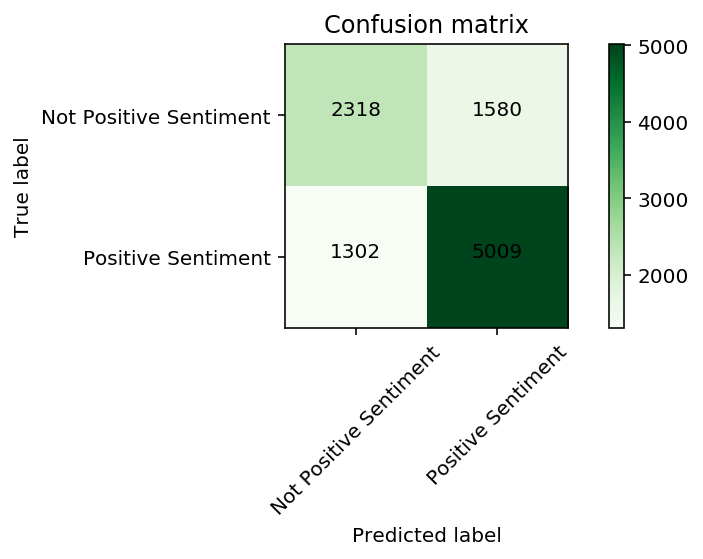

In [23]:
import itertools
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

AUC is 0.6942


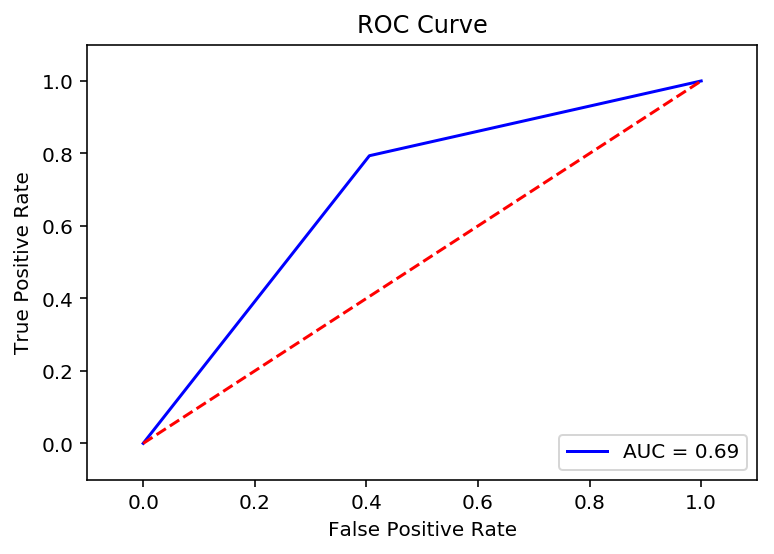

In [24]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Save Model

In [25]:
import os

import pickle as pkl

# See https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
# Need to save with joblib or pickle.  `xgb.save_model()` does not save feature_names
model_dir  = './models/notebook/'

os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'xgboost-model')

pkl.dump(xgb_estimator, open(model_path, 'wb'))

print('Wrote model to {}'.format(model_path))

Wrote model to ./models/notebook/xgboost-model


# Restore Model 
This simulates restoring a model within an application.

In [26]:
import pickle as pkl
import os

model_dir  = './models/notebook/'
model_path = os.path.join(model_dir, 'xgboost-model')

xgb_estimator = pkl.load(open(model_path, 'rb'))

type(xgb_estimator)

xgboost.sklearn.XGBClassifier

# Confirm the Predictions are OK from the Restored Model

In [27]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test))
print('Test Precision: ', precision_score(y_test, preds_test, average=None))

Test Accuracy:  0.7177000685669507
Test Precision:  [0.64033149 0.7602064 ]
